In [1]:
%matplotlib inline

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import animation
import torchvision.transforms as transforms
import torchvision.models as models
import seaborn as sns
import numpy as np
import copy
import random 

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style('darkgrid')

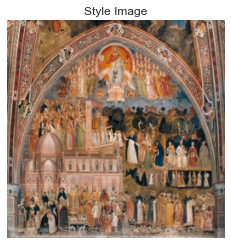

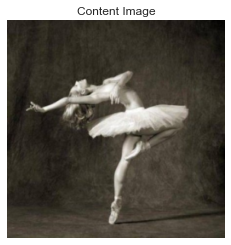

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
style_path = "data/fresco.jpg"
content_path = "data/dancing.jpg"
imsize = list(Image.open(content_path).size[::-1])

# to check if the image size is greater or lower than 512 px

for i in range(2):
    imsize[i] = int(imsize[i]*256/max(imsize))
imsize = tuple(imsize)

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    if image.shape[1] != 3:
        image = image[:,:3] # removing alpha channel
    return image.to(device, torch.float)


style_img = image_loader(style_path)
content_img = image_loader(content_path)

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)  
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
plt.axis('off')
plt.grid(b=None)
imshow(style_img, title='Style Image')

plt.figure()
plt.axis('off')
plt.grid(b=None)
imshow(content_img, title='Content Image')

In [3]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super().__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

    
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = self.gram_matrix(target_feature).detach()
        
    def gram_matrix(self,input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

    
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [4]:
cnn = models.alexnet(pretrained=True).features.to(device).eval()

normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

content_layers = ['conv_3']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4' , 'conv_5']


normalization = Normalization(normalization_mean, normalization_std).to(device)

content_losses = []
style_losses = []


model = nn.Sequential(normalization)

i = 0
for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
        
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        layer = nn.ReLU(inplace=False)
        
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
        
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
        
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)

    if name in style_layers:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)

for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break

model = model[:(i + 1)]

C:\Users\GOKULA~1\AppData\Local\Temp/ipykernel_6740/2892532387.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\GOKULA~1\AppData\Local\Temp/ipykernel_6740/2892532387.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [5]:
input_img = content_img.clone() # Use this for faster convergence
#input_img = torch.randn(content_img.data.size(), device=device) 
input_img.requires_grad_(True)
model.requires_grad_(False)
optimizer = optim.LBFGS([input_img]) #We are using input_img instead of model.parameters bcos input_img is modified

# optimizer = optim.Adam([input_img],lr = 0.001) #use epoch 24000

epoch = 500
log_idx = int(epoch/10)
style_weight , content_weight = 10000 , 100
loss_history = []
img_history = []
img_history.append(input_img.clone())

In [6]:
e = [0]

def closure():
    with torch.no_grad():
        input_img.clamp_(0, 1)
        
    optimizer.zero_grad()
    model(input_img)
    
    temp_style_loss = 0
    temp_content_loss = 0
    
    for i in style_losses:
        temp_style_loss = temp_style_loss + i.loss
        
    for i in content_losses:
        temp_content_loss = temp_content_loss + i.loss
    
    loss = temp_style_loss*style_weight + temp_content_loss*content_weight
    loss.backward()
    loss_history.append(loss.item())
    img_history.append(input_img.clone())
    
    if e[0]%log_idx == 0 :
        print(f'Loss for Epoch {e[0]+1} : {round(loss_history[-1],2)}')
        
    e[0] = e[0] + 1
    return loss

while e[0] <= epoch:
    optimizer.step(closure)

# #Adam Optimzation Method

# for e in range(epoch):
#     with torch.no_grad():
#         input_img.clamp_(0, 1)
        
#     optimizer.zero_grad()
#     model(input_img)
    
#     temp_style_loss = 0
#     temp_content_loss = 0
    
#     for i in style_losses:
#         temp_style_loss = temp_style_loss + i.loss
        
#     for i in content_losses:
#         temp_content_loss = temp_content_loss + i.loss
    
#     loss = temp_style_loss*style_weight + temp_content_loss*content_weight
#     loss.backward()
#     optimizer.step()
    
#     loss_history.append(loss.item())
#     if e%log_idx == 0 :
#         print(f'Loss for Epoch {e+1} : {round(loss_history[-1],2)}')
#         img_history.append(input_img.clone())

Loss for Epoch 1 : 8257.06
Loss for Epoch 51 : 666.52
Loss for Epoch 101 : 605.71
Loss for Epoch 151 : 581.6
Loss for Epoch 201 : 569.36
Loss for Epoch 251 : 561.16
Loss for Epoch 301 : 553.22
Loss for Epoch 351 : 548.41
Loss for Epoch 401 : 544.74
Loss for Epoch 451 : 541.4
Loss for Epoch 501 : 536.05


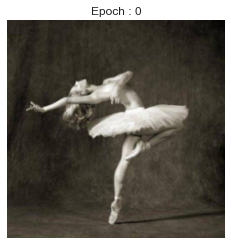

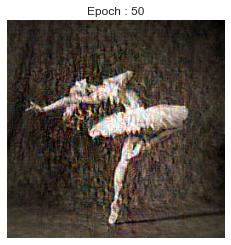

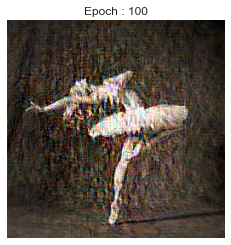

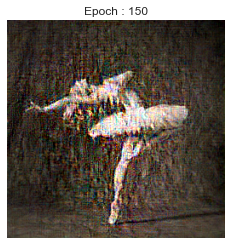

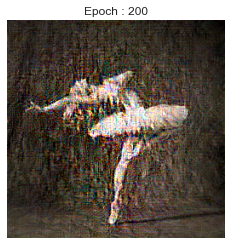

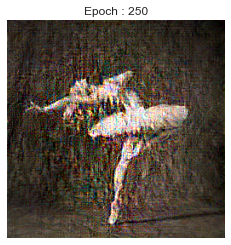

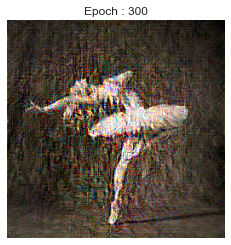

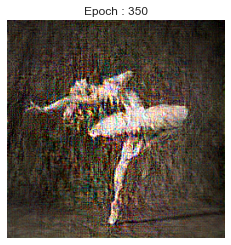

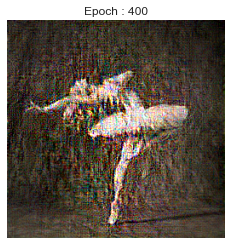

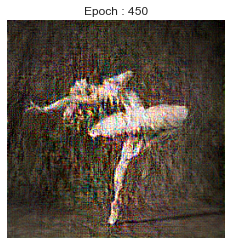

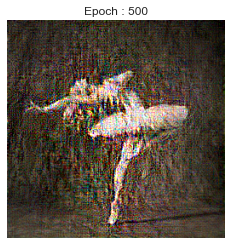

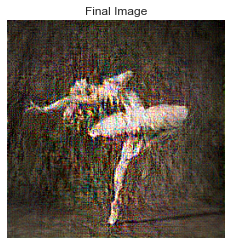

In [7]:
for i in range(0,len(img_history),log_idx):
    plt.figure()
    plt.axis('off')
    plt.grid(b=None)
    imshow(img_history[i], title=f'Epoch : {i}')
    plt.show()

plt.figure()
plt.axis('off')
plt.grid(b=None)
imshow(img_history[-1], title='Final Image')
plt.show()

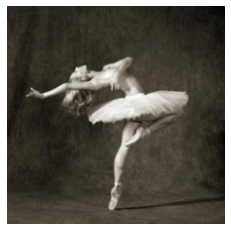

In [8]:
nSeconds = 5
fps = int(len(img_history)/nSeconds)

fig = plt.figure()

def return_imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)  
    image = unloader(image)
    return plt.imshow(image)
    if title is not None:
        plt.title(title)

i = 0
im = return_imshow(img_history[i])

def updatefig(*args):
    global i
    i = i + 1
    if i == len(img_history):
        i = 0
        
    image = img_history[i].cpu().clone()  
    image = image.squeeze(0)  
    image = unloader(image)
    im.set_array(image)
    
    return im,

anim = animation.FuncAnimation(
                               fig, 
                               updatefig, 
                               frames = len(img_history),
                               interval = 1000 / fps, # in ms
                               )
plt.axis('off')
plt.grid(b=None)

In [9]:
from IPython.display import HTML
HTML(anim.to_html5_video())